In [23]:
# importando datasets
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_rows', 4000)
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score


import xgboost as xgb
import lightgbm as lgb


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_path = "/content/drive/MyDrive/TeraFraude/"

Mounted at /content/drive


In [3]:
df_fraud = pd.read_csv('transactions.csv')
print(df_fraud.shape)
df_fraud.sample(5)

(3776513, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3052260,234,CASH_IN,408470.38000,C848346233,1221832.69000,1630303.07000,C1307819396,981349.93000,572879.55000,0.00000,0.00000
284501,15,PAYMENT,6279.13000,C1569754349,0.00000,0.00000,M1005755362,0.00000,0.00000,0.00000,0.00000
2064618,181,CASH_OUT,69602.01000,C85211895,0.00000,0.00000,C1276881061,11431588.86000,11501190.87000,0.00000,0.00000
878353,42,CASH_OUT,635515.40000,C970444798,0.00000,0.00000,C1676147214,1963394.00000,2598909.41000,0.00000,0.00000
2655887,209,CASH_IN,47329.36000,C1283415032,1684073.11000,1731402.47000,C1499693543,280825.15000,233495.79000,0.00000,0.00000


In [4]:
df_fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
df_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,3776513.00000,3776513.00000,3776513.00000,3776513.00000,3776513.00000,3776513.00000,3776512.00000,3776512.00000
mean,151.09695,155933.94257,838943.36973,860378.25528,993204.04083,1095579.49764,0.00084,0.00000
std,86.34149,308813.36609,2905207.10051,2941593.48307,2310984.24182,2406655.43871,0.02896,0.00089
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,43.00000,12334.28000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,164.00000,74943.13000,14556.00000,0.00000,136095.19000,219963.06000,0.00000,0.00000
75%,226.00000,208209.65000,110989.00000,149776.55000,937983.77000,1112626.06000,0.00000,0.00000
max,280.00000,92445516.64000,38939424.03000,38946233.02000,146412656.59000,192624577.51000,1.00000,1.00000


In [6]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3776513 entries, 0 to 3776512
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 316.9+ MB


In [7]:
df_fraud.isna().mean()

step             0.00000
type             0.00000
amount           0.00000
nameOrig         0.00000
oldbalanceOrg    0.00000
newbalanceOrig   0.00000
nameDest         0.00000
oldbalanceDest   0.00000
newbalanceDest   0.00000
isFraud          0.00000
isFlaggedFraud   0.00000
dtype: float64

In [8]:
df_fraud['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

## Análise Exploratória

CASH_OUT    1341282
PAYMENT     1272450
CASH_IN      827560
TRANSFER     311967
DEBIT         23254
Name: type, dtype: int64


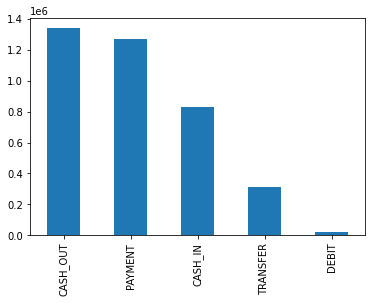

In [9]:
# Visualização gráfica
print(df_fraud['type'].value_counts(ascending=False))
df_fraud['type'].value_counts().plot(kind="bar")


In [10]:
df_fraud.duplicated().mean()


0.0

### Variável Target


0.00000    3773341
1.00000       3171
Name: isFraud, dtype: int64


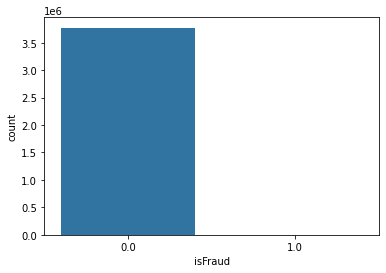

In [11]:
print(df_fraud['isFraud'].value_counts())
sns.countplot(x="isFraud", data=df_fraud)

In [12]:
df_fraud['isFraud'].mean()*100

0.08396636896691974

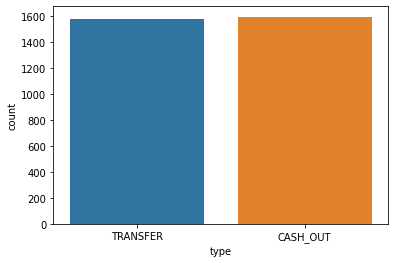

In [13]:
df_isfraud = df_fraud[df_fraud['isFraud']==1]
sns.countplot(x="type", data=df_isfraud)

In [14]:
## volumetria de fraude por pagamento
counts = df_fraud.groupby('type')['isFraud'].count()
sum  = df_fraud.groupby('type')['isFraud'].sum().round(5)
#total = df_fraud.groupby('type')[].count()
#pd.DataFrame(data={'counts':counts, 'means':means}).sort_values(by=['counts'], ascending=[False]).head(100)
#pd.DataFrame(data={'counts':counts, 'means':means}).sort_index(ascending=[False]).head(100)
pd.DataFrame(data={'counts':counts, 'sum':sum}).sort_values(by=['counts'], ascending=[False]).head(100)


,counts,sum
type,,
CASH_OUT,1341282,1595.00000
PAYMENT,1272449,0.00000
CASH_IN,827560,0.00000
TRANSFER,311967,1576.00000
DEBIT,23254,0.00000


------------
Tipos de transação (do maior para o menor): PAYMENT, CASH_OUT, CASH_IN, TRANSFER, DEBIT

Apenas transações do tipo CASH_OUT (2a) e TRANSFER (4a) possuem casos fraudulentos. Podemos criar uma hipótese de que o modo de operação das transações fraudulentas são de transferência de todo o valor de uma conta para outra específica e em seguida o saque dessas contas.


### Será que existe um padrão de contas para transações fraudulentas?

#### Primeiramente vamos ver se existe padrão entre as contas



In [15]:
df_fraudnew = df_fraud.copy() 
df_fraudnew["typeClient"] = np.nan 

df_fraudnew.loc[df_fraud['nameOrig'].str.contains('C') & df_fraud['nameDest'].str.contains('C'),"typeClient"] = "CC" 
df_fraudnew.loc[df_fraud['nameOrig'].str.contains('C') & df_fraud['nameDest'].str.contains('M'),"typeClient"] = "CM"
df_fraudnew.loc[df_fraud['nameOrig'].str.contains('M') & df_fraud['nameDest'].str.contains('C'),"typeClient"] = "MC"
df_fraudnew.loc[df_fraud['nameOrig'].str.contains('M') & df_fraud['nameDest'].str.contains('M'),"typeClient"] = "MM"


In [16]:
## volumetria de fraude por pagamento
counts = df_fraudnew.groupby('typeClient')['isFraud'].count()
sum  = df_fraudnew.groupby('typeClient')['isFraud'].sum()
#total = df_fraud.groupby('typeClient')[].count()
#pd.DataFrame(data={'counts':counts, 'means':means}).sort_values(by=['counts'], ascending=[False]).head(100)
#pd.DataFrame(data={'counts':counts, 'means':means}).sort_index(ascending=[False]).head(100)
pd.DataFrame(data={'counts':counts, 'sum':sum}).sort_values(by=['counts'], ascending=[False])


,counts,sum
typeClient,,
CC,2504063,3171.00000
CM,1272449,0.00000


#### E agora veremos se existe alguma correlação entre a quantia total de transferência

In [17]:
# Categorização do amount(quantia total transferida) com base na mediana e no 1 quartil
#1o quartil -> 9011.0125
#mediana - 44049.185
#3o -> 199130.74
def transfer_category(x):
    if x >= 199130.74:
        return('HIGH')
    elif x > 9011.0125 and x < 199130.74:
        return('MODERATE')
    elif x < 9011.0125:
        return('LOW')
    else:
        return("EXTREMLY LOW")
df_fraudnew['amountCategory'] = df_fraudnew.amount.apply(transfer_category)    
df_fraudnew.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,typeClient,amountCategory
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0.00000,0.00000,CM,MODERATE
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0.00000,0.00000,CM,LOW
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1.00000,0.00000,CC,LOW
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1.00000,0.00000,CC,LOW
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0.00000,0.00000,CM,MODERATE
5,1,PAYMENT,7817.71000,C90045638,53860.00000,46042.29000,M573487274,0.00000,0.00000,0.00000,0.00000,CM,LOW
6,1,PAYMENT,7107.77000,C154988899,183195.00000,176087.23000,M408069119,0.00000,0.00000,0.00000,0.00000,CM,LOW
7,1,PAYMENT,7861.64000,C1912850431,176087.23000,168225.59000,M633326333,0.00000,0.00000,0.00000,0.00000,CM,LOW
8,1,PAYMENT,4024.36000,C1265012928,2671.00000,0.00000,M1176932104,0.00000,0.00000,0.00000,0.00000,CM,LOW
9,1,DEBIT,5337.77000,C712410124,41720.00000,36382.23000,C195600860,41898.00000,40348.79000,0.00000,0.00000,CC,LOW


In [18]:
## volumetria de fraude por pagamento
counts = df_fraudnew.groupby('amountCategory')['isFraud'].count()
sum  = df_fraudnew.groupby('amountCategory')['isFraud'].sum()
#total = df_fraud.groupby('type')[].count()
#pd.DataFrame(data={'counts':counts, 'means':means}).sort_values(by=['counts'], ascending=[False]).head(100)
#pd.DataFrame(data={'counts':counts, 'means':means}).sort_index(ascending=[False]).head(100)
pd.DataFrame(data={'counts':counts, 'sum':sum}).sort_values(by=['sum'], ascending=[False]).head(100)


,counts,sum
amountCategory,,
HIGH,995705,2062.00000
MODERATE,2032562,1008.00000
LOW,748245,101.00000


--------------------------
É interessante perceber que as transações que mais foram feitas foram as categorizadas como moderadas, porém o tipo de transação que mais possui casos fraudulentos são as consideradas 'altas'.

#### Por fim, podemos partir para uma análise horária dos casos de fraude:

In [19]:
num_days = 7
num_hours = 24
df_fraudnew['hours'] = df_fraud['step'] % num_hours


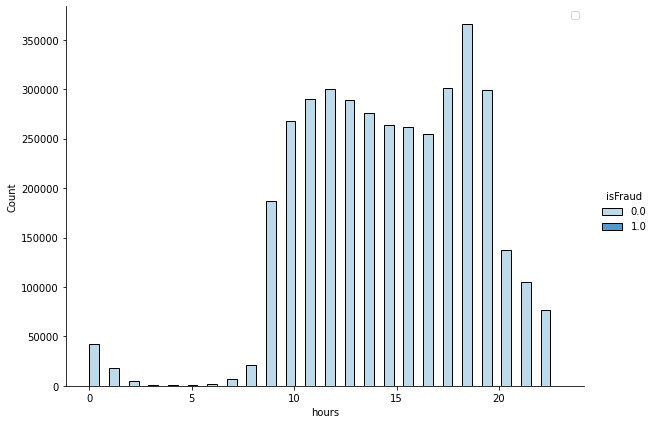

In [20]:

sns.displot(data = df_fraudnew, x = 'hours', palette = 'Paired', bins = 24, height = 6, aspect = 1.4, hue='isFraud', multiple='dodge')
#sns.histplot(df["age"], kde = True,bins = 18)
#plt.axvline(df["fare"].median(), c="red", label="Median fare: {:.1f}".format(df["fare"].median()))
#plt.axvline(df["fare"].mean(), c="blue", label="Mean fare: {:.1f}".format(df["fare"].mean()))
plt.legend()
plt.show()

--------------
Aqui podemos ver que é durante o horário em que quase não são realizadas transações válidas que ocorrem as transações fraudulentas, entre as 3h e as 6h da manhã.

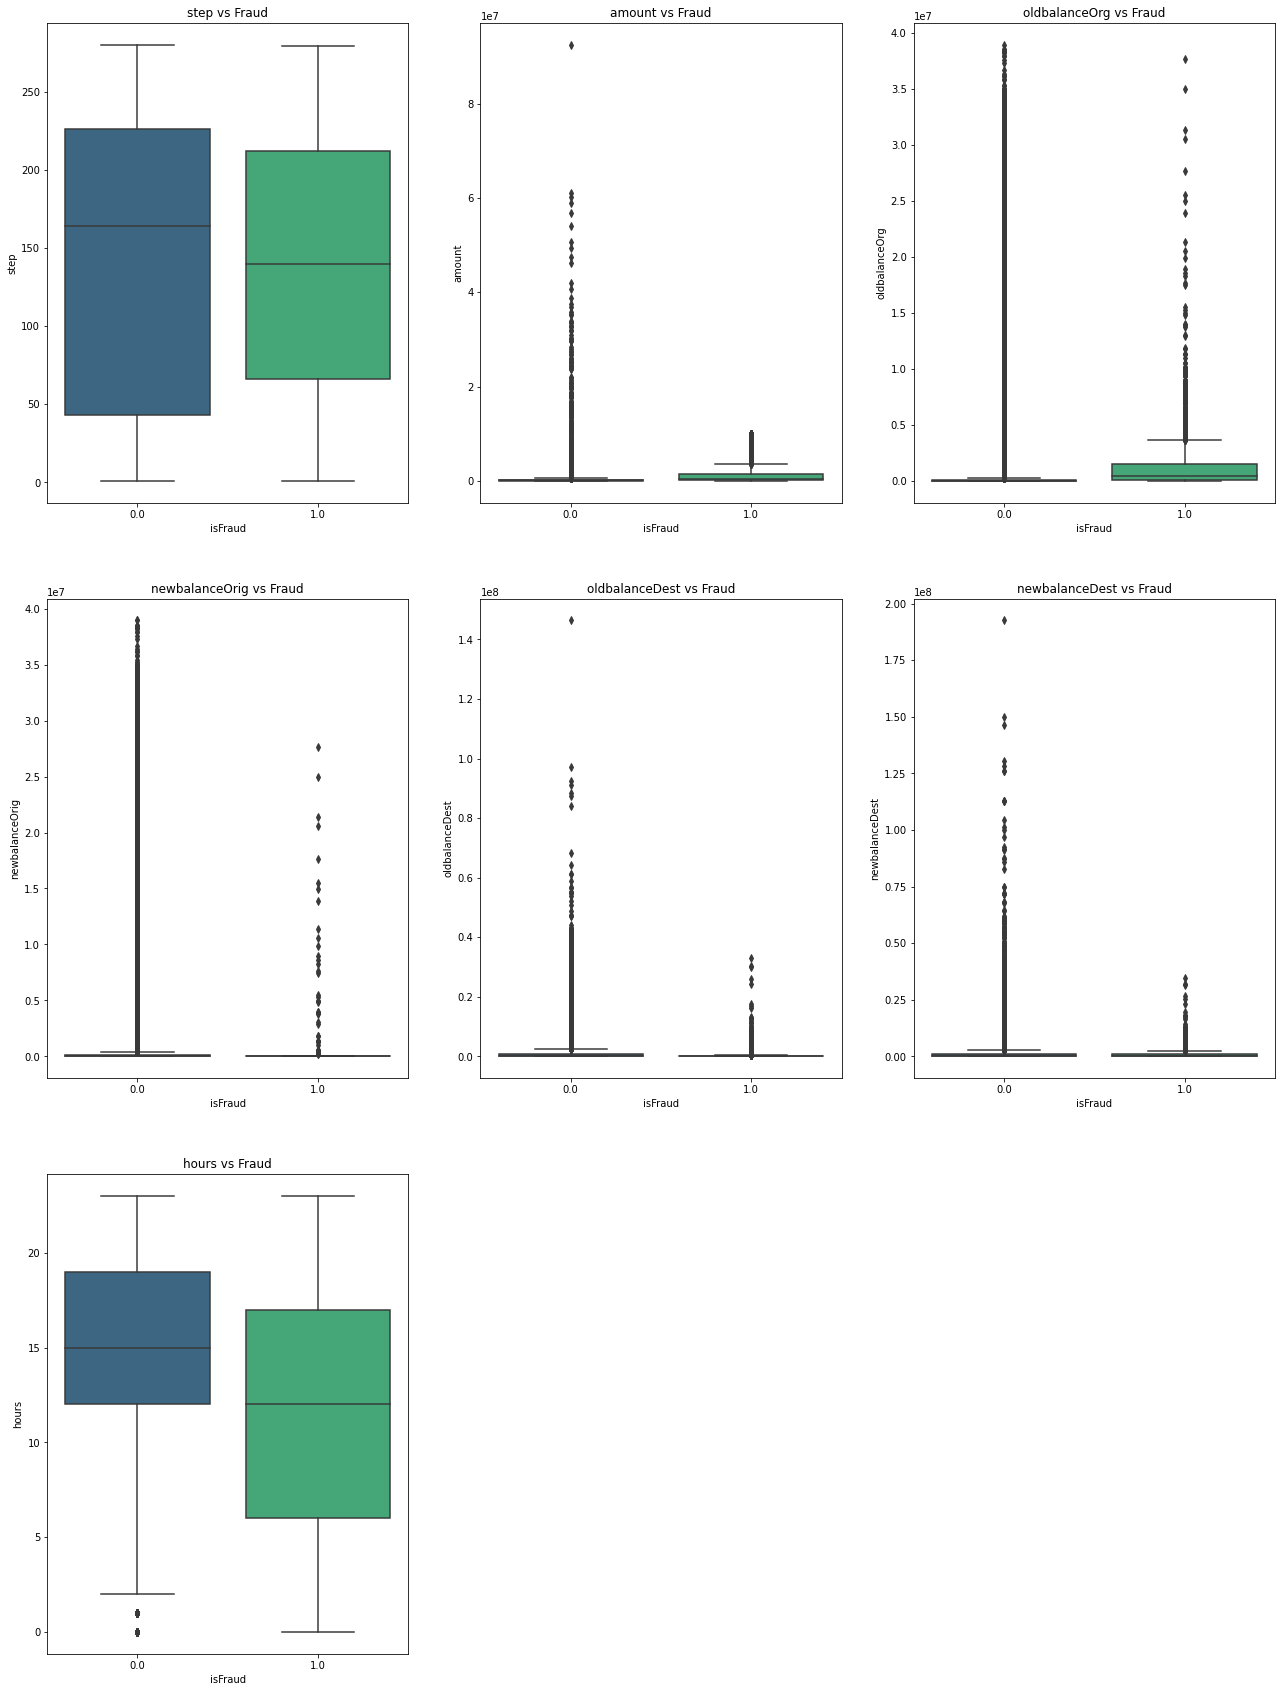

In [21]:
#visualizando as variáveis
features = df_fraudnew[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                        'oldbalanceDest', 'newbalanceDest', 'hours']]

plt.figure(figsize = (22,30 ))
x = 1
for d in features:
    plt.subplot(3, 3, x)
    sns.boxplot(data = features, x = df_fraudnew['isFraud'], y = d, palette = 'viridis')
    plt.title('%s vs Fraud' %(d))
    x += 1

In [27]:
label_encoder = LabelEncoder() 
df_fraudnew['type_encode'] = label_encoder.fit_transform(df_fraudnew['type']) 
df_fraudnew['amountCategory_encode'] = label_encoder.fit_transform(df_fraudnew['amountCategory'])
df_fraudnew['typeClient_encode'] = label_encoder.fit_transform(df_fraudnew['typeClient'])

In [28]:
# selecionando as variáveis que serão utilizadas:
features_final = df_fraudnew[['step', 'type_encode', 'amountCategory_encode', 'oldbalanceOrg', 
                              'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest',
       'typeClient_encode', 'amountCategory', 'hours', 'isFraud']]

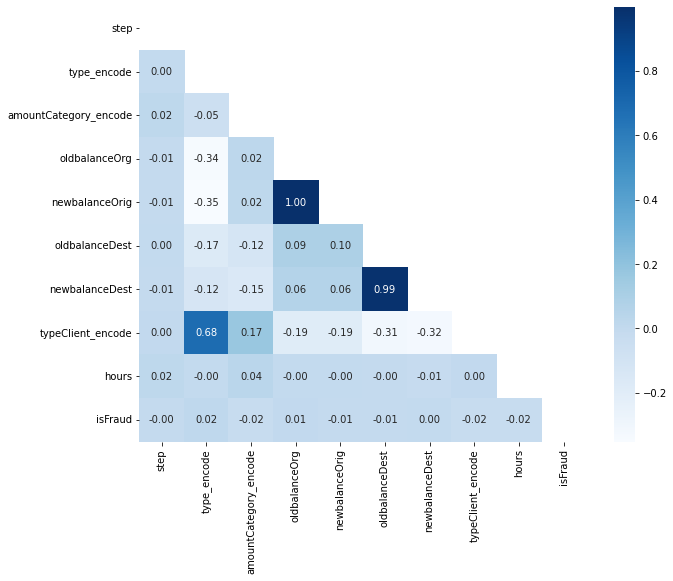

In [32]:
plt.figure(figsize = (10,8))
sns.set_context(font_scale = 3.9)
sns.heatmap(
    features_final.corr(), 
    mask = np.triu(np.ones_like(features_final.corr())),
    cmap = 'Blues',
    fmt = ".2f",
    annot = True
    )
plt.show()

## Pre Processamento de dados

In [60]:
df_fraudnew.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'typeClient', 'amountCategory', 'hours',
       'type_encode', 'nameOrig_encode', 'nameDest_encode',
       'amountCategory_encode', 'typeClient_encode', 'amount_stand',
       'oldbalanceOrg_stand', 'newbalanceOrig_stand', 'oldbalanceDest_stand',
       'newbalanceDest_stand', 'hours_stand'],
      dtype='object')

### Balanceando o dataset com SMOTE

In [9]:
X = df_fraudnew[['type_encode', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest',
       'amountCategory_encode', 'typeClient_encode', 'amount', 'hours']]
y = df_fraudnew[['isFraud']]

In [10]:
y = y.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


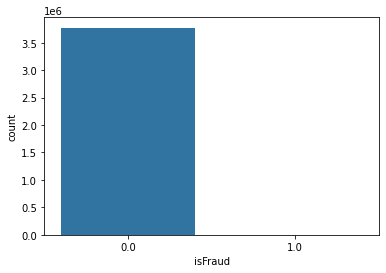

In [15]:
sns.countplot(y['isFraud'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


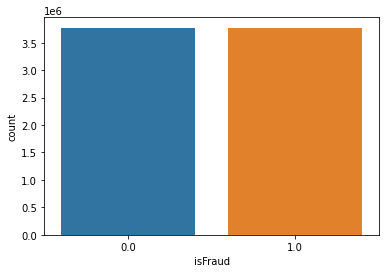

In [14]:
#Importing SMOTE
from imblearn.over_sampling import SMOTE
#Oversampling the data
smote = SMOTE(random_state = 109)
X_smote, y_smote = smote.fit_resample(X, y)
#Creating a new Oversampling Data Frame
sns.countplot(y_smote['isFraud'])


### Divisão treino e teste 

In [16]:

# Train-test split
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, train_size=0.7, random_state=111)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=111)




### StandardScaler

In [ ]:
#Standardizing the numerical columns
scaler = StandardScaler()
col_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
             'newbalanceDest', 'hours', 'type_encode', 'amountCategory_encode', 
             'typeClient_encode']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = scaler.fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] =features_test

features_train_smote = X_train_smote[col_names]
features_test_smote = X_test_smote[col_names]
scaler = scaler.fit(features_train_smote.values)
features_train_smote = scaler.transform(features_train_smote.values)
features_test_smote = scaler.transform(features_test_smote.values)
X_train_smote[col_names] = features_train_smote
X_test_smote[col_names] =features_test_smote



In [19]:
y_train.head()

,isFraud
1089717,0.00000
2581969,0.00000
41674,0.00000
2012078,0.00000
512096,0.00000


In [20]:
y_train_smote.head()

,isFraud
6310833,1.00000
2419959,0.00000
2915058,0.00000
5491128,1.00000
2319538,0.00000


## Treinamento de Modelos

### 1. Base desbalanceada

In [34]:

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

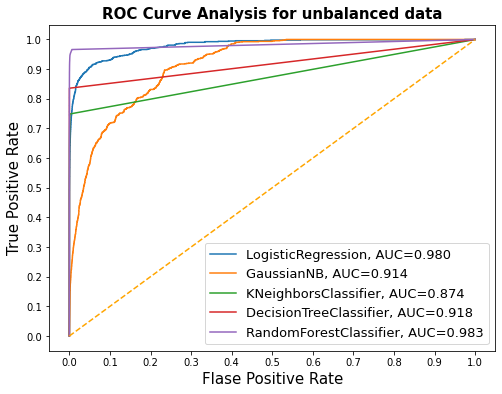

In [71]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis for unbalanced data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

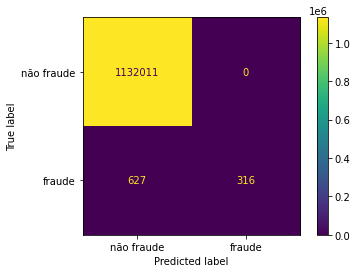

In [69]:
cm__ = confusion_matrix(y_test, yproba.astype(np.int64))
disp_ = ConfusionMatrixDisplay(confusion_matrix = cm__, display_labels=['não fraude', 'fraude'])
a_ = disp_.plot(values_format='d') 

### Base SMOTE

In [ ]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

# Define a result table as a DataFrame
result_table_smote = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_smote, y_train_smote)
    yproba_smote = model.predict_proba(X_test_smote)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_smote,  yproba_smote)
    auc = roc_auc_score(y_test_smote, yproba_smote)
    
    result_table_smote = result_table_smote.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table_smote.set_index('classifiers', inplace=True)


In [33]:
result_table_smote

,fpr,tpr,auc
classifiers,,,
LogisticRegression,"[0.0, 8.833071727192347e-07, 8.833071727192347...","[0.0, 0.17307758568138268, 0.17845263305760153...",0.99229
GaussianNB,"[0.0, 0.0019114767217644237, 0.001989207752963...","[0.0, 0.17235755550195822, 0.1773085360240375,...",0.90988
KNeighborsClassifier,"[0.0, 0.0025395081215677994, 0.004565814775785...","[0.0, 0.9989336485563616, 0.9995008379737732, ...",0.99871
DecisionTreeClassifier,"[0.0, 0.0007781936191656457, 1.0]","[0.0, 0.9997111044556174, 1.0]",0.99947
RandomForestClassifier,"[0.0, 2.29659864907001e-05, 2.29659864907001e-...","[0.0, 0.9754359274739662, 0.9754385778918047, ...",0.99999


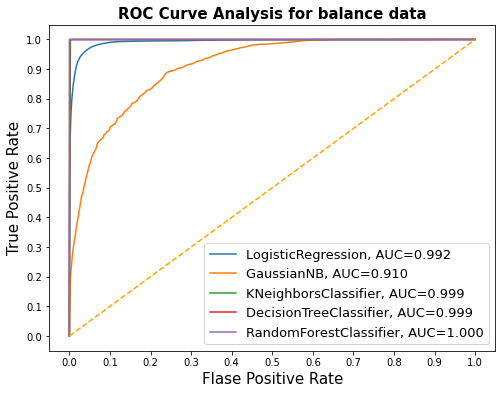

In [72]:
fig = plt.figure(figsize=(8,6))

for i in result_table_smote.index:
    plt.plot(result_table_smote.loc[i]['fpr'], 
             result_table_smote.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table_smote.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis for balance data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

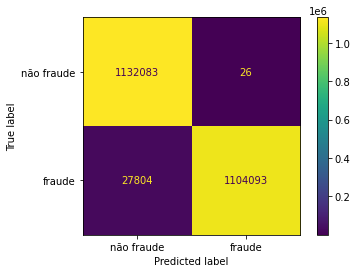

In [70]:
cm = confusion_matrix(y_test_smote, yproba_smote.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels=['não fraude', 'fraude'])
_ = disp.plot(values_format='d') 